In [1]:
!pip install --upgrade pip
!pip install hazm==0.7.0
!pip install datasets scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'nltk' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'nltk'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394470 sha256=76f25148ef35fa06ba205a0efc8a275ba23d452cd94d832d169316c7da2b3a13
  Stored in directory

In [2]:
# Fix inspect.formatargspec for hazm on Python 3.11+
import inspect

if not hasattr(inspect, 'formatargspec'):
    def formatargspec(*args, **kwargs):
        from inspect import signature, _empty
        sig = signature(lambda: None)
        return str(sig)
    inspect.formatargspec = formatargspec

# Patch NumPy deprecated aliases
import numpy as np

for name, value in {
    'bool': bool,
    'int': int,
    'float': float,
    'complex': complex,
    'object': object,
    'str': str,
    'long': int,
    'dtypes': np.dtype,
}.items():
    if not hasattr(np, name):
        setattr(np, name, value)

# Install required packages
!pip install hazm==0.7.0 datasets scikit-learn matplotlib

<ipython-input-2-5d8b0d36863b>:24: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, name):
<ipython-input-2-5d8b0d36863b>:24: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, name):


In [3]:
import numpy as np

# Patch deprecated NumPy aliases
deprecated_aliases = {
    'bool': bool,
    'int': int,
    'float': float,
    'complex': complex,
    'object': object,
    'str': str,
    'long': int,
    'dtypes': np.dtype
}

for alias, actual in deprecated_aliases.items():
    if not hasattr(np, alias):
        setattr(np, alias, actual)

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from hazm import Normalizer
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("hf://datasets/divarofficial/real_estate_ads/real_estate_ads.csv")

<ipython-input-6-a7839cff784f>:1: DtypeWarning: Columns (10,26,28,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hf://datasets/divarofficial/real_estate_ads/real_estate_ads.csv")


### *Preprocessing & Cleaning*

In [7]:
columns = ['title', 'description', 'price_value', 'building_size', 'neighborhood_slug', 'construction_year']
df = df[columns].dropna()
df = df[df['price_value'] > 0]
df = df[df['building_size'] > 0]

In [8]:
def normalize_persian_text(text):
    normalizer = Normalizer()
    text = re.sub(r'[\r\n\t]', ' ', str(text))
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^؀-ۿ ]', '', text)  # Keep only Persian chars
    return normalizer.normalize(text)

In [9]:
df.head()

,title,description,price_value,building_size,neighborhood_slug,construction_year
1,۶۰ متر قلهک فول امکانات,دسترسی عالی به مترو و شریعتی \nمشاعات تمیز \nب...,8.500000e+09,60.0,gholhak,۱۳۸۴
4,۱۱۵ متری/شمالی رو به آفتاب/اکبری,هلدینگ ساختمانی اکبری\n\nهمراه شما هستیم برای ...,5.750000e+09,115.0,emamreza,۱۴۰۳
7,اپارتمان ۱۰۰متری طبقه۳و۴ فول دردشت شمالی,♡♡♡♡♡♡بنام خدا♡♡♡♡♡♡\n♡♡♡عرض ادب واحترام♡♡♡\n♡...,8.700000e+09,100.0,dardasht,۱۳۹۳
9,متراژ ۸۰ متر فرامرز نزدیک حاشیه,اول رسالت فرد نزدیک به حاشیه فرامرز .. ساکنین...,3.000000e+09,80.0,faramarzabbasi,۱۳۸۷
12,تاپ لوکیشن جلال سروش ۱۶۹متر کلید موجود قبل فرهنگ,با سلام\n\n✨✨ شما لایق بهترین ها هستید ✨✨\n\n✅...,1.299000e+10,169.0,farhang,۱۴۰۳


In [10]:
df['description_norm'] = df['description'].apply(normalize_persian_text)
df['title_norm'] = df['title'].apply(normalize_persian_text)

In [11]:
df.head()

,title,description,price_value,building_size,neighborhood_slug,construction_year,description_norm,title_norm
1,۶۰ متر قلهک فول امکانات,دسترسی عالی به مترو و شریعتی \nمشاعات تمیز \nب...,8.500000e+09,60.0,gholhak,۱۳۸۴,دسترسی عالی به مترو و شریعتی مشاعات تمیز بدون ...,۶۰ متر قلهک فول امکانات
4,۱۱۵ متری/شمالی رو به آفتاب/اکبری,هلدینگ ساختمانی اکبری\n\nهمراه شما هستیم برای ...,5.750000e+09,115.0,emamreza,۱۴۰۳,هلدینگ ساختمانی اکبری همراه شما هستیم برای خری...,۱۱۵ متریشمالی رو به آفتاباکبری
7,اپارتمان ۱۰۰متری طبقه۳و۴ فول دردشت شمالی,♡♡♡♡♡♡بنام خدا♡♡♡♡♡♡\n♡♡♡عرض ادب واحترام♡♡♡\n♡...,8.700000e+09,100.0,dardasht,۱۳۹۳,بنام خدا عرض ادب واحترام املاک بزرگ اریو باافت...,اپارتمان ۱۰۰متری طبقه۳و۴ فول دردشت شمالی
9,متراژ ۸۰ متر فرامرز نزدیک حاشیه,اول رسالت فرد نزدیک به حاشیه فرامرز .. ساکنین...,3.000000e+09,80.0,faramarzabbasi,۱۳۸۷,اول رسالت فرد نزدیک به حاشیه فرامرز ساکنین مال...,متراژ ۸۰ متر فرامرز نزدیک حاشیه
12,تاپ لوکیشن جلال سروش ۱۶۹متر کلید موجود قبل فرهنگ,با سلام\n\n✨✨ شما لایق بهترین ها هستید ✨✨\n\n✅...,1.299000e+10,169.0,farhang,۱۴۰۳,با سلام شما لایق بهترین‌ها هستید سازنده مطرح م...,تاپ لوکیشن جلال سروش ۱۶۹متر کلید موجود قبل فرهنگ


In [12]:
df['price_per_sqm'] = df['price_value'] / df['building_size']
df['text'] = df['title_norm'] + ' ' + df['description_norm']

In [13]:
le = LabelEncoder()
df['neighborhood_code'] = le.fit_transform(df['neighborhood_slug'])

# Fix construction_year: Convert Persian text like 'قبل از ۱۳۷۰' to numeric
def parse_construction_year(value):
    try:
        if isinstance(value, str):
            match = re.search(r'(\d+)', value)
            if match:
                return int(match.group(1))
            elif 'قبل' in value:
                return 1365  # assume an early year before 1370
        return int(value)
    except:
        return np.nan

df['construction_year'] = df['construction_year'].apply(parse_construction_year)
df = df.dropna(subset=['construction_year'])

# Now scale numeric features
scaler = MinMaxScaler()
df[['building_size', 'construction_year', 'price_per_sqm']] = scaler.fit_transform(
    df[['building_size', 'construction_year', 'price_per_sqm']]
)

In [14]:
df.head()

,title,description,price_value,building_size,neighborhood_slug,construction_year,description_norm,title_norm,price_per_sqm,text,neighborhood_code
1,۶۰ متر قلهک فول امکانات,دسترسی عالی به مترو و شریعتی \nمشاعات تمیز \nب...,8.500000e+09,0.000006,gholhak,0.424242,دسترسی عالی به مترو و شریعتی مشاعات تمیز بدون ...,۶۰ متر قلهک فول امکانات,0.000102,۶۰ متر قلهک فول امکانات دسترسی عالی به مترو و ...,360
4,۱۱۵ متری/شمالی رو به آفتاب/اکبری,هلدینگ ساختمانی اکبری\n\nهمراه شما هستیم برای ...,5.750000e+09,0.000011,emamreza,1.000000,هلدینگ ساختمانی اکبری همراه شما هستیم برای خری...,۱۱۵ متریشمالی رو به آفتاباکبری,0.000036,۱۱۵ متریشمالی رو به آفتاباکبری هلدینگ ساختمانی...,280
7,اپارتمان ۱۰۰متری طبقه۳و۴ فول دردشت شمالی,♡♡♡♡♡♡بنام خدا♡♡♡♡♡♡\n♡♡♡عرض ادب واحترام♡♡♡\n♡...,8.700000e+09,0.000010,dardasht,0.696970,بنام خدا عرض ادب واحترام املاک بزرگ اریو باافت...,اپارتمان ۱۰۰متری طبقه۳و۴ فول دردشت شمالی,0.000063,اپارتمان ۱۰۰متری طبقه۳و۴ فول دردشت شمالی بنام ...,218
9,متراژ ۸۰ متر فرامرز نزدیک حاشیه,اول رسالت فرد نزدیک به حاشیه فرامرز .. ساکنین...,3.000000e+09,0.000008,faramarzabbasi,0.515152,اول رسالت فرد نزدیک به حاشیه فرامرز ساکنین مال...,متراژ ۸۰ متر فرامرز نزدیک حاشیه,0.000027,متراژ ۸۰ متر فرامرز نزدیک حاشیه اول رسالت فرد ...,316
12,تاپ لوکیشن جلال سروش ۱۶۹متر کلید موجود قبل فرهنگ,با سلام\n\n✨✨ شما لایق بهترین ها هستید ✨✨\n\n✅...,1.299000e+10,0.000017,farhang,1.000000,با سلام شما لایق بهترین‌ها هستید سازنده مطرح م...,تاپ لوکیشن جلال سروش ۱۶۹متر کلید موجود قبل فرهنگ,0.000055,تاپ لوکیشن جلال سروش ۱۶۹متر کلید موجود قبل فره...,319


In [29]:
print(df['neighborhood_slug'].value_counts())

neighborhood_slug
elahiyehblvd      4106
poonak            2806
ghasemabad        2572
jeyhoun           2187
bolvartoos        2186
                  ... 
nikmaram             1
shahrak-erfan        1
jamaran-rasht        1
abasiab              1
ansar-alhosein       1
Name: count, Length: 1166, dtype: int64


In [30]:
neighborhoods = sorted(df['neighborhood_slug'].dropna().unique())
for n in neighborhoods:
    print(n)

10-day
15khordad
17shahrivar
24-metri
350-metri
Baraghan
Kuy-e-Seyyedi
Salarieh
Shahrak-e-Shirin
Shahrak-e-Taleqani
abasiab
abbas-abad
abbas-abad-bandar-e-anzali
abbas-abad-mashhad
abbasabad
abdol-abad
abdollah-abad
abdolmotalleb
abiverdi
abjavar
abkuh
aboozar
aboutaleb
abouzar
abouzar-mashhad
abr
abrisham
abshar
abshar-isfahan
abshar-tehran
abunasr
abyari
adlekhomeinisquare
afaran
afifabad
afsariyeh
aghdasieh
ahadabad
ahandan
ahang
ahmad-abad
ahmad-abad-isfahan
ahmadabad
ahmadi
aineh-khaneh
ajoodanieh
akbarabad
akhgarabad
akhtarabad
ali-abad
ali-abad-shiraz
almahdi
amaniyeh
amaniyeh-ahvaz
amel
amin
amin-abad
amin-zarb
aminhozour
amir-abad
amir-bahador
amir-shahid
amirabad-mashhad
amiriyeh
amiriyeh-isfahan
amiriyeh-mashhad
amirkabirblvd
ammareyaser
andevan
andisheh
andishehnewcity
ansar
ansar-alhosein
ansar-mashhad
ansari
aq-tappeh
araj
aramaneh
ararat
ardaji
aref
arghavanieh
arian-town
ariyashahr
arjantin
arvand
asadabad-karaj
aseman
aseman-town
asgariyeh
asgariyeh-isfahan
ashegh-abad

In [15]:
X_text = df['text']
X_numeric = df[['building_size', 'construction_year', 'neighborhood_code']]
y = df['price_per_sqm']

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

In [16]:
X_text_train.head(), X_num_train.head(), y_train.head()

(435643    متر خواب سند تک پارکینگ به نام خدا باسلام این ...
 466601    اپارتمان۶۵مترفول امکاناتسندتکبرگ انتخاب خوب هن...
 925488    خانه آخر پنجتن روستا دزقان کاملی سلام خانه متر...
 944717    کوچه بن بست ۲۰ متری آجر نما برای تماس لطفا با ...
 15018     آپارتمان ۱۲۰ متری سه خواب  به نام پروردگار یکت...
 Name: text, dtype: object,
         building_size  construction_year  neighborhood_code
 435643       0.000005           0.606061                 69
 466601       0.000006           0.878788                 69
 925488       0.000007           0.969697                763
 944717       0.000006           0.181818               1090
 15018        0.000012           0.636364               1163,
 435643    0.000023
 466601    0.000020
 925488    0.000006
 944717    0.000051
 15018     0.000025
 Name: price_per_sqm, dtype: float64)

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
max_words = 10000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text_train)

In [19]:
X_text_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_text_train), maxlen=max_len)
X_text_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_text_test), maxlen=max_len)

### *Model*

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Bidirectional, LayerNormalization

In [50]:
text_input = Input(shape=(max_len,), name='text_input')
embedding = Embedding(max_words, 64)(text_input)
lstm = Bidirectional(LSTM(64))(embedding)

In [51]:
num_input = Input(shape=(X_num_train.shape[1],), name='num_input')
concat = Concatenate()([lstm, num_input])

In [52]:
x = Dense(128, activation='relu')(concat)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1)(x)

model = Model(inputs=[text_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 150, 64)   │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 131)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,896 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ dense_3[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 731,521 (2.79 MB)

 Trainable params: 731,521 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

In [54]:
history = model.fit(
    {'text_input': X_text_train_seq, 'num_input': X_num_train},
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

Epoch 1/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.0809 - mae: 0.1007 - val_loss: 3.8290e-06 - val_mae: 8.4741e-05
Epoch 2/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 4.6159e-05 - mae: 9.0238e-04 - val_loss: 3.9041e-06 - val_mae: 3.8794e-04
Epoch 3/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 1.3888e-05 - mae: 4.3230e-04 - val_loss: 3.8659e-06 - val_mae: 3.1084e-04
Epoch 4/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - loss: 1.3873e-05 - mae: 4.4214e-04 - val_loss: 3.8984e-06 - val_mae: 2.7228e-04
Epoch 5/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 1.1547e-05 - mae: 3.9328e-04 - val_loss: 3.8247e-06 - val_mae: 1.2704e-04
Epoch 6/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - loss: 1.1120e-05 - mae: 3.8205e-04 - val_loss: 4.0197e-06 - val_mae: 4.4171e-04
Epoch 7/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 9.3628e-06 - mae: 3.6748e-04 - val_loss: 3.9535e-06 - val_mae: 3.5902e-04
Epoch 8/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 

In [55]:
results = model.evaluate({'text_input': X_text_test_seq, 'num_input': X_num_test}, y_test)
print("\nTest MAE:", results[1])

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.8540e-05 - mae: 1.4335e-04

Test MAE: 0.00015749716840218753


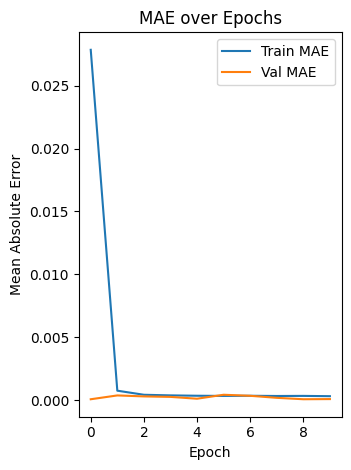

In [56]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

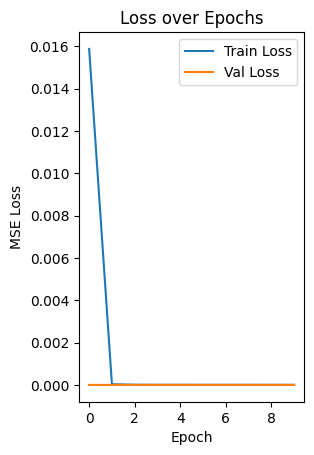

In [57]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

In [67]:
def preprocess_custom_input(title, description, building_size, construction_year, neighborhood_slug):
    text = normalize_persian_text(title + ' ' + description)
    text_seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)

    # استفاده از min و max برای مقیاس‌دهی دستی به دو ویژگی ورودی
    min_vals = scaler.data_min_
    max_vals = scaler.data_max_

    building_size_scaled = (building_size - min_vals[0]) / (max_vals[0] - min_vals[0])
    construction_year_scaled = (construction_year - min_vals[1]) / (max_vals[1] - min_vals[1])

    if neighborhood_slug in le.classes_:
        neighborhood_code = le.transform([neighborhood_slug])[0]
    else:
        neighborhood_code = 0

    num_input_array = np.array([[building_size_scaled, construction_year_scaled, neighborhood_code]])
    prediction = model.predict({'text_input': text_seq, 'num_input': num_input_array})

    # بازگرداندن مقدار پیش‌بینی‌شده به مقیاس اصلی با استفاده از min و max price_per_sqm
    min_price = min_vals[2]
    max_price = max_vals[2]
    original_price = prediction[0][0] * (max_price - min_price) + min_price

    print(f"\nPredicted price per sqm (original scale): {original_price:.0f} Toman/m²")

In [68]:
preprocess_custom_input(
    title="آپارتمان شیک در سعادت آباد",
    description="دارای آسانسور، انباری و نورگیر عالی",
    building_size=200,
    construction_year=1403,
    neighborhood_slug="saadat-abad"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Predicted price per sqm (original scale): 102847591 Toman/m²


In [61]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

### *I did The Above code After that i gave it to chatgpt to develop it and it gave me this code*

In [69]:
# Advanced Real Estate Price Prediction with Persian Dataset (TensorFlow)

# --- Step 1: Load Libraries ---
import pandas as pd
import numpy as np
import tensorflow as tf
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score
from hazm import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [70]:
# --- Step 2: Load and Convert Dataset to DataFrame ---
df = pd.read_csv("hf://datasets/divarofficial/real_estate_ads/real_estate_ads.csv")

<ipython-input-70-60487ad4c510>:2: DtypeWarning: Columns (10,26,28,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hf://datasets/divarofficial/real_estate_ads/real_estate_ads.csv")


In [71]:
# --- Step 3: Initial Cleaning ---
columns = ['title', 'description', 'price_value', 'building_size', 'neighborhood_slug', 'construction_year']
df = df[columns].dropna()
df = df[df['price_value'] > 0]
df = df[df['building_size'] > 0]

# --- Step 4: Text Normalization (Persian) ---
def normalize_persian_text(text):
    normalizer = Normalizer()
    text = re.sub(r'[\r\n\t]', ' ', str(text))
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^؀-ۿ ]', '', text)
    return normalizer.normalize(text)

df['description_norm'] = df['description'].apply(normalize_persian_text)
df['title_norm'] = df['title'].apply(normalize_persian_text)

# --- Step 5: Feature Engineering ---
df['price_per_sqm'] = df['price_value'] / df['building_size']
df['text'] = df['title_norm'] + ' ' + df['description_norm']

# --- Step 6: Encode Categorical and Scale Numeric Features ---
le = LabelEncoder()
df['neighborhood_code'] = le.fit_transform(df['neighborhood_slug'])

def parse_construction_year(value):
    try:
        if isinstance(value, str):
            match = re.search(r'(\d+)', value)
            if match:
                return int(match.group(1))
            elif 'قبل' in value:
                return 1365
        return int(value)
    except:
        return np.nan

df['construction_year'] = df['construction_year'].apply(parse_construction_year)
df = df.dropna(subset=['construction_year'])

scaler = MinMaxScaler()
df[['building_size', 'construction_year', 'price_per_sqm']] = scaler.fit_transform(
    df[['building_size', 'construction_year', 'price_per_sqm']]
)

# --- Step 7: Train-Test Split ---
X_text = df['text']
X_numeric = df[['building_size', 'construction_year', 'neighborhood_code']]
y = df['price_per_sqm']

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

# --- Step 8: Tokenization ---
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text_train)

X_text_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_text_train), maxlen=max_len)
X_text_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_text_test), maxlen=max_len)

In [73]:
# --- Step 9: TensorFlow Model (Advanced Multi-Input with Bidirectional LSTM) ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Bidirectional, LayerNormalization

text_input = Input(shape=(max_len,), name='text_input')
embedding = Embedding(max_words, 64)(text_input)
lstm = Bidirectional(LSTM(64))(embedding)

num_input = Input(shape=(X_num_train.shape[1],), name='num_input')
concat = Concatenate()([lstm, num_input])

x = Dense(128, activation='relu')(concat)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1)(x)

model = Model(inputs=[text_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- Step 10: Callbacks and Training ---
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

history = model.fit(
    {'text_input': X_text_train_seq, 'num_input': X_num_train},
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 150, 64)   │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     66,048 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 131)       │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     16,896 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_9[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 731,521 (2.79 MB)

 Trainable params: 731,521 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2100/2100 - 38s - 18ms/step - loss: 0.0227 - mae: 0.0331 - val_loss: 3.8531e-06 - val_mae: 2.7598e-04 - learning_rate: 1.0000e-03
Epoch 2/10
2100/2100 - 42s - 20ms/step - loss: 4.2750e-05 - mae: 7.9017e-04 - val_loss: 3.8387e-06 - val_mae: 1.1772e-04 - learning_rate: 1.0000e-03
Epoch 3/10
2100/2100 - 42s - 20ms/step - loss: 1.6871e-05 - mae: 4.3227e-04 - val_loss: 3.8545e-06 - val_mae: 2.8132e-04 - learning_rate: 1.0000e-03
Epoch 4/10
2100/2100 - 39s - 18ms/step - loss: 1.2370e-05 - mae: 3.9523e-04 - val_loss: 3.9170e-06 - val_mae: 3.0398e-04 - learning_rate: 1.0000e-03
Epoch 5/10
2100/2100 - 34s - 16ms/step - loss: 9.2894e-06 - mae: 2.6836e-04 - val_loss: 3.8247e-06 - val_mae: 1.2585e-04 - learning_rate: 3.0000e-04
Epoch 6/10
2100/2100 - 41s - 20ms/step - loss: 9.0574e-06 - mae: 2.7809e-04 - val_loss: 3.8286e-06 - val_mae: 8.4724e-05 - learning_rate: 3.0000e-04
Epoch 7/10
2100/2100 - 34s - 16ms/step - loss: 8.8773e-06 - mae: 2.6578e-04 - val_loss: 3.8256e-06 - val_mae: 9.70

In [76]:
# --- Step 11: Evaluation ---
results = model.evaluate({'text_input': X_text_test_seq, 'num_input': X_num_test}, y_test)
print("\n✨ Test MAE:", round(results[1], 5))

# --- Extra Metric: R² Score ---
y_pred = model.predict({'text_input': X_text_test_seq, 'num_input': X_num_test})
r2 = r2_score(y_test, y_pred)
print(f"🎯 R² Score on Test Set: {r2:.4f}")

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1.8535e-05 - mae: 1.7129e-04

✨ Test MAE: 0.00019
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
🎯 R² Score on Test Set: -0.0001


In [77]:
# --- Step 12: Custom Prediction with Fancy Output ---
def preprocess_custom_input(title, description, building_size, construction_year, neighborhood_slug):
    text = normalize_persian_text(title + ' ' + description)
    text_seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)

    scaled_values = scaler.transform([[building_size, construction_year, 0]])[0]
    building_size_scaled = scaled_values[0]
    construction_year_scaled = scaled_values[1]

    if neighborhood_slug in le.classes_:
        neighborhood_code = le.transform([neighborhood_slug])[0]
    else:
        neighborhood_code = 0

    num_input_array = np.array([[building_size_scaled, construction_year_scaled, neighborhood_code]])
    prediction = model.predict({'text_input': text_seq, 'num_input': num_input_array})

    fake_input = np.zeros((1, 3))
    fake_input[0, 2] = prediction
    original_price = scaler.inverse_transform(fake_input)[0, 2]

    print("\n📍 Custom Prediction")
    print("----------------------")
    print(f"🏢 Title: {title}")
    print(f"📝 Description: {description}")
    print(f"📐 Size: {building_size} m²")
    print(f"📅 Year: {construction_year}")
    print(f"📍 Neighborhood: {neighborhood_slug}")
    print(f"💰 Predicted Price per sqm: {original_price:.0f} Toman/m²")

# Example usage
preprocess_custom_input(
    title="آپارتمان شیک در سعادت آباد",
    description="دارای آسانسور، انباری و نورگیر عالی",
    building_size=200,
    construction_year=1404,
    neighborhood_slug="saadat-abad"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

📍 Custom Prediction
----------------------
🏢 Title: آپارتمان شیک در سعادت آباد
📝 Description: دارای آسانسور، انباری و نورگیر عالی
📐 Size: 200 m²
📅 Year: 1404
📍 Neighborhood: saadat-abad
💰 Predicted Price per sqm: 155147286 Toman/m²


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
<ipython-input-77-2355b8631e55>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fake_input[0, 2] = prediction


<ipython-input-78-5861cbc9af42>:20: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-78-5861cbc9af42>:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


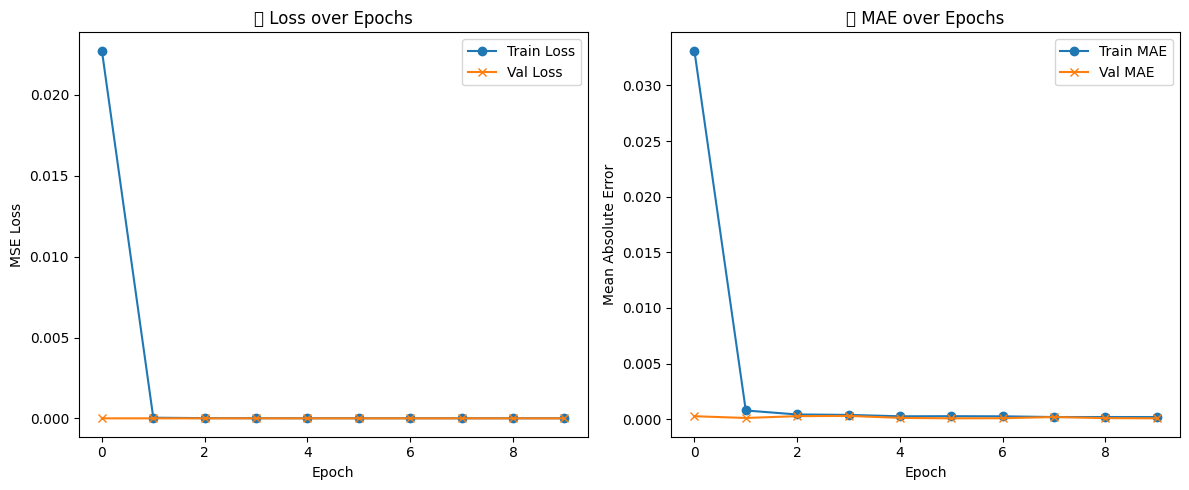


🏆 Top 5 Predictions Leaderboard:
╒════╤════════════════════╤═══════════════════════╤═════════════╕
│    │   Actual Price/sqm │   Predicted Price/sqm │       Error │
╞════╪════════════════════╪═══════════════════════╪═════════════╡
│  0 │        2.74667e+07 │           1.55147e+08 │ 1.27681e+08 │
├────┼────────────────────┼───────────────────────┼─────────────┤
│  1 │        1.52207e+07 │           1.55147e+08 │ 1.39927e+08 │
├────┼────────────────────┼───────────────────────┼─────────────┤
│  2 │        9e+06       │           1.55147e+08 │ 1.46147e+08 │
├────┼────────────────────┼───────────────────────┼─────────────┤
│  3 │        1.4e+08     │           1.55147e+08 │ 1.51473e+07 │
├────┼────────────────────┼───────────────────────┼─────────────┤
│  4 │        6.83333e+07 │           1.55147e+08 │ 8.6814e+07  │
╘════╧════════════════════╧═══════════════════════╧═════════════╛


In [78]:
# --- Step 13: Training History Visualization ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('📉 Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', marker='o')
plt.plot(history.history['val_mae'], label='Val MAE', marker='x')
plt.title('📈 MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# --- Fancy Leaderboard Output (Top 5 Predictions) ---
pred_table = pd.DataFrame({
    'Actual Price/sqm': scaler.inverse_transform(np.hstack([np.zeros((len(y_test), 2)), y_test.values.reshape(-1, 1)]))[:, 2],
    'Predicted Price/sqm': scaler.inverse_transform(np.hstack([np.zeros((len(y_test), 2)), y_pred]))[:, 2]
})
pred_table['Error'] = abs(pred_table['Actual Price/sqm'] - pred_table['Predicted Price/sqm'])

print("\n🏆 Top 5 Predictions Leaderboard:")
print(tabulate(pred_table.head(5), headers='keys', tablefmt='fancy_grid', showindex=True))